# ADTObsBox calibration from a.u. to micrometers

In [1]:
import numpy as np
import pandas as pd
import os
import json
import getpass
import logging
import sys
import numpy as np
import datetime
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import glob
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as mpatches

/tmp/ipykernel_1153/830197416.py:22: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


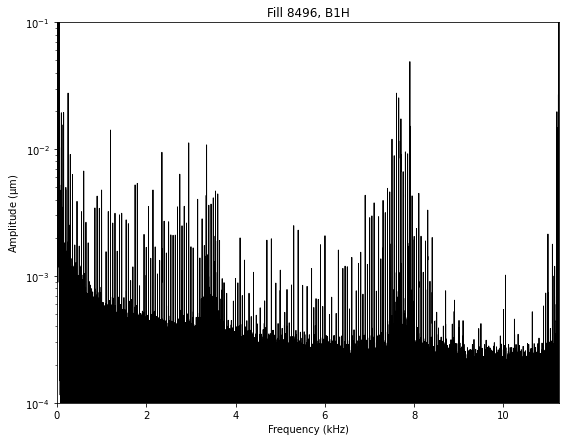

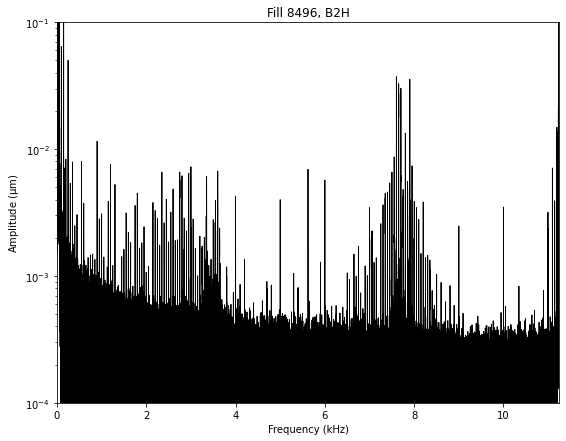

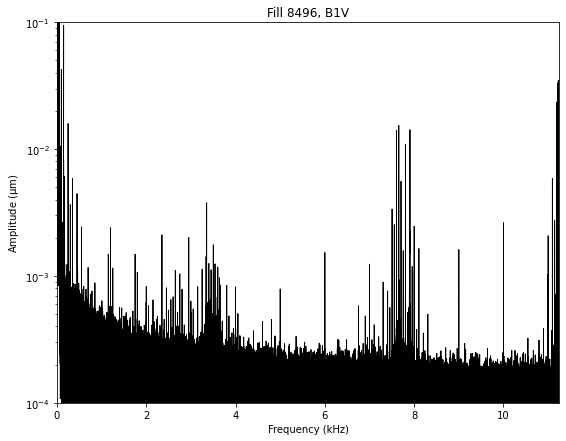

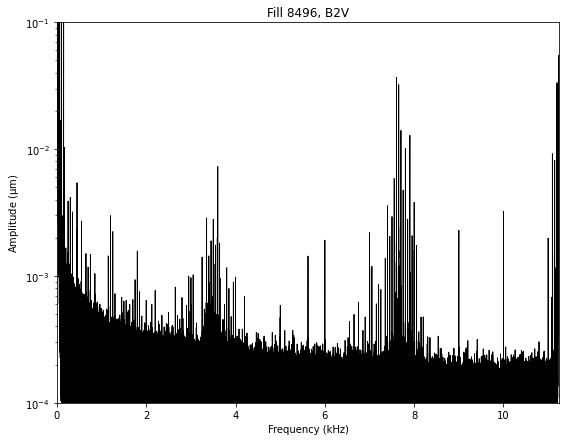

In [4]:
path = '/eos/user/a/aradosla/SWAN_projects/Analysis/ADTObsBox_analysis/results_nxcals/'
fills = ['8496']
for fill_nb in fills:
    if fill_nb == '8182':
        plot_beam_mode = False
    else:
        plot_beam_mode = True

    for beam_plane in ['B1H', 'B2H', 'B1V', 'B2V']:
        #beam_plane = 'B2H'
        file = glob.glob(f"{path}/*{fill_nb}/{beam_plane}/*.parquet")[0]
        #print(file)
        df = pd.read_parquet(file, engine='pyarrow')
        #display(df.dropna())
        df[df.columns[0]] = df[df.columns[0]].apply(lambda x: x['elements'])
        df.index = [pd.Timestamp(df.index[i]) for i in range(len(df))]

        df_fills = pd.read_parquet("fills.parquet")
        if df_fills['HX:FILLN'].iloc[0] == None:
            df_fills['HX:FILLN'].iloc[0] = df_fills['HX:FILLN'].dropna().iloc[0]
        df_fills['HX:FILLN'] = df_fills['HX:FILLN'].ffill(axis=0)
        df_fills = df_fills[df_fills['HX:FILLN'] == fill_nb]
        df_fills.index = [pd.Timestamp(df_fills.index[i]) for i in range(len(df_fills))]
        #print(df_fills)

        df_bunches = df_fills[f'LHC.BQM.B{beam_plane[1:2]}:NO_BUNCHES'].dropna().astype(int)
        bunches = df_bunches.max()

        if beam_plane == 'B1H':
            xxx = [30540, -22596]
            yyy = [1.1603166, -1.190074]

        elif beam_plane == 'B1V':
            xxx = [29084, -19520]
            yyyy = [1.03086, -0.97900736]
            
        elif beam_plane == 'B2H':
            xxx = [19196, -8556]
            yyy = [0.9960319, -0.9899802]

        elif beam_plane == 'B2V':
            xxx = [31436, -25916]
            yyy = [1.1303835, -1.1762166]

        fig, ax = plt.subplots(figsize=(9,7))
        frev = 11245.5
        #print(df[df.columns[0]].iloc[0])
        #print(df.iloc[-2].values[0])
        freqs = np.linspace(0, frev, len(df[df.columns[0]].iloc[0]))
        #print(beam_plane, np.polyfit(xxx, yyy, 1))
        mycalib = np.poly1d(np.polyfit(xxx, yyy, 1))(df.iloc[-2].values[0])* 1.585
        #print(df)
        plt.semilogy(freqs/1e3, (mycalib-np.min(mycalib))*1e3, c='k', lw=0.9)
        plt.ylim(1e-4, 1e-1)
        plt.xlim(0, 11245.5/1e3)

        plt.ylabel(r"$\rm Amplitude ~ (\mu m)$")
        plt.xlabel("Frequency (kHz)")
        plt.title(f"Fill {fill_nb}, {beam_plane}")
        #plt.semilogy(freqs, (df.iloc[-1].values[0]*6.10e-8)*1e6)
        fig.savefig(f"calib_FFT_fill8496_{beam_plane}.png")